### **PR0206: Ingesta de datos financieros en InfluxDB**

### **Objetivo de la Práctica**

En esta práctica vamos a crear un un agente de ingestión en Python que lea múltiples ficheros CSV de cotizaciones, los procese y los almacene de manera eficiente en un Bucket de InfluxDB, aplicando el modelo de datos correcto (Tags y Fields).

Para ello vamos a trabajar con el dataset Cryptocurrency Historical Prices de Kaggle, que contiene datos sobre la evolución de precios de 23 criptomonedas entre los años 2017 y 2021.

Para realizar esta práctica tienes que tener en cuenta lo siguiente:

- Nombre del bucket: crypto_raw.
- Measurement: daily_quote
Y Mapearás las siguientes columnas del fichero CSV.

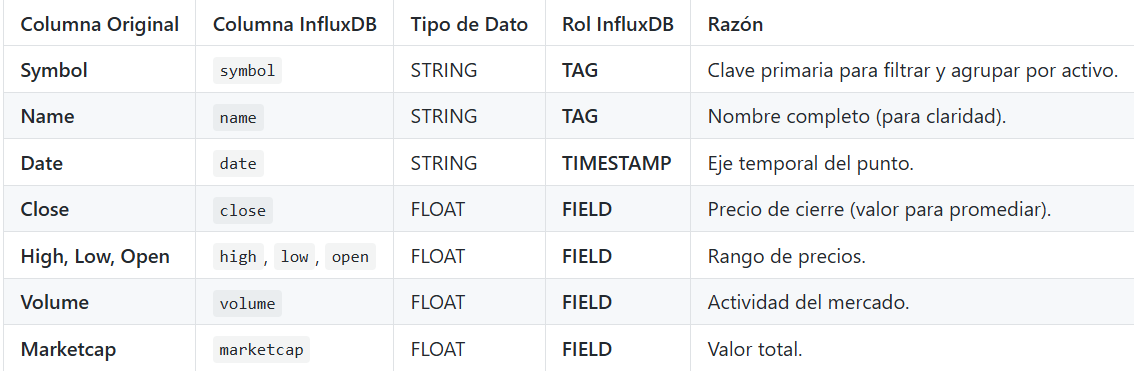

Debes desarrollar el script ``ingesta_crypto.py`` que realice los siguientes pasos:

1. Usa el módulo ``os`` para listar los 23 ficheros en el directorio ``/data/crypto_files/``.
2. Configura el ``InfluxDBClient`` y la ``WriteAPI`` en **modo Asíncrono (ASYNCHRONOUS)** con un tamaño de batch definido (p.e. **5000 puntos**).
3. Inicializa un contador global de puntos insertados.
4. Dentro del **bucle** de lectura de ficheros (usando el módulo ``csv.reader`` para manejo de CSV):
- Omite la primera línea (cabecera) de cada fichero.
- Asegúrate de convertir los campos (``Close``, ``Volume``, ``Marketcap``, etc.) ``float`` antes de ser asignados al ``Point``.
- Por cada fila, construye un objeto ``Point`` que respete el modelo definido, usando el campo ``Date`` como el ``Timestamp`` del punto.
5. Después de procesar cada fichero, imprime un mensaje (``Ej: Fichero BTC.csv procesado``).
6. Al finalizar el bucle de ficheros, llamar a **``write_api.close()``** para vaciar los puntos restantes del buffer antes de que el script termine.



## **Entrega**

El fichero Markdown de la entrega debe incluir:
1. El script ``ingesta_crypto.py`` funcionando.
2. Captura de pantalla de la terminal mostrando el **total de puntos insertados** (que debe ser la suma de todas las filas en los 23 ficheros).
3. Captura de pantalla de la interfaz web de InfluxDB (``Data Explorer``) mostrando un gráfico de la métrica ``close`` para el activo **BTCUSDT**, verificando que los datos se han cargado correctamente.

In [4]:
import os
import csv
def ingesta_crypto():
    archivos = os.listdir("./data/crypto_files/")
        
    import influxdb_client
    from influxdb_client.client.write_api import ASYNCHRONOUS, WriteOptions
    from influxdb_client.client.exceptions import InfluxDBError
    from urllib3.exceptions import NewConnectionError
    from influxdb_client import Point
    
    INFLUX_URL = "http://influxdb-influxdb2-1:8086"
    INFLUX_TOKEN = "MyInitialAdminToken0="
    
    print("--- Iniciando conexión a InfluxDB ---")
    
    client = None
    
    try:
        client = influxdb_client.InfluxDBClient(
            url=INFLUX_URL,
            token=INFLUX_TOKEN,
            org="docs"
            )
        print(f"Verificando estado de salud de InfluxDB en {INFLUX_URL}")
        health = client.health()
        
        if health.status == "pass":
            print("[INFO] ¡Conexión Exitosa!")
            print(f"[INFO] Versión del servidor: {health.version}")
            ##Aqui va la logica
            write_api = client.write_api(
                        write_options=WriteOptions(
                        batch_size=5000,
                        flush_interval=5000,
                            )
            )
        
            # Tenemos una lista de ficheros, tenemos que recorrer cada uno de los ficheros
            contador = 0
            for archivo in archivos:
                ruta = "./data/crypto_files/" + archivo
                #Una vez tenemos cada archivo, lo abrimos y leemos su contenido
                if os.path.isdir(ruta): #Nos saltamos los directorios
                    continue
                with open(ruta, "r") as csvfile:
                    reader = csv.reader(csvfile)
                    next(reader) #Saltamos Cabecera
                    #Ahora tenemos que leer el documento fila por fila
                    for row in reader:
                        #mediante de descompresion cogemos los valores
                        SNO, Name, Symbol, Date, High, Low, Open, Close, Volume, Marketcap = row
                        p = Point("daily_quotes") \
                        .tag("symbol",Symbol) \
                        .tag("name",Name) \
                        .field("close",float(Close)) \
                        .field("high",float(High)) \
                        .field("low",float(Low)) \
                        .field("open",float(Open)) \
                        .field("volume",float(Volume)) \
                        .field("marketcap",float(Marketcap)) \
                        .time(Date)
                        write_api.write(bucket="crypto_raw",org="docs", record=p, write_precision="s") 
                        contador += 1
                        
            write_api.close() #Cerramos la conexion tras poner todos los puntos            
            print(contador)
        else:
            print(f"[Error] Conexion fallida. Estado: {health.status}")
            print(f"[INFO] Mensaje: {health.message}")
    except (InfluxDBError,NewConnectionError) as e:
        print("[ERROR] Error al conectar con InfluxDB:")
        print(f" Detalle: {e}")
    finally:
        if client:
            client.close()
            print("--- Conexión Cerrada ---")

In [5]:
ingesta_crypto()

--- Iniciando conexión a InfluxDB ---
Verificando estado de salud de InfluxDB en http://influxdb-influxdb2-1:8086
[INFO] ¡Conexión Exitosa!
[INFO] Versión del servidor: v2.7.12
35628
--- Conexión Cerrada ---


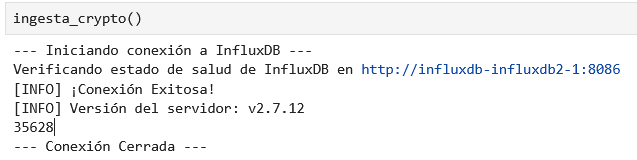

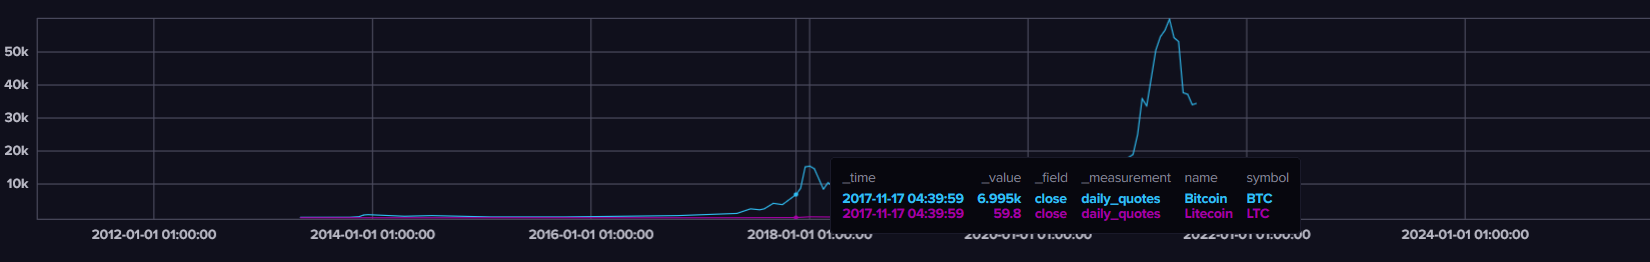